In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [94]:
df = pd.read_csv('../lab1/Exasens.csv')
df = df.drop(index=[0, 1])

feature_cols = ['Imaginary Part (Min)', 'Imaginary Part (Avg)', 'Real Part (Min)', 'Real Part (Avg)', 'Gender', 'Age', 'Smoking']
target_cols = ['Diagnosis']

df = df.loc[:, feature_cols + target_cols]

original_rows = len(df)
df.dropna(inplace=True)
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
deleted_rows = original_rows - len(df)
print(f"{deleted_rows}/{len(df)}/{original_rows}")

dfX = df.loc[:, feature_cols]
dfy = df.loc[:, target_cols]
replace_dict = { 'COPD': 0, 'HC': 1, 'Asthma': 2, 'Infected': 3 }
dfy['Diagnosis'] = dfy['Diagnosis'].replace(replace_dict)
X = dfX.to_numpy()
scaler = MinMaxScaler(feature_range=(0.1, 0.9))
X = scaler.fit_transform(X)
y = dfy.to_numpy().flatten()

299/100/399


In [95]:
dfX.head()

,Imaginary Part (Min),Imaginary Part (Avg),Real Part (Min),Real Part (Avg),Gender,Age,Smoking
2,-320.61,-300.563531,-495.26,-464.171991,1.0,77.0,2.0
3,-325.39,-314.750360,-473.73,-469.263140,0.0,72.0,2.0
4,-323.00,-317.436056,-476.12,-471.897667,1.0,73.0,3.0
5,-327.78,-317.399670,-473.73,-468.856388,1.0,76.0,2.0
6,-325.39,-316.155785,-478.52,-472.869783,0.0,65.0,2.0


In [96]:
dfy.head()

,Diagnosis
2,0
3,0
4,0
5,0
6,0


In [97]:
print(dfy['Diagnosis'].unique())

[0 1 2 3]


In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        features = torch.tensor(self.X.T[0:7].T, dtype=torch.float32)
        target = torch.tensor(self.y.T[-1].T, dtype=torch.float32)
        return features, target

In [99]:
dataset = CustomDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [51]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(7, 2), 
            nn.ReLU(True),
            nn.Linear(2, 2),      
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(True),
            nn.Linear(2, 7),
            nn.Sigmoid()          
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

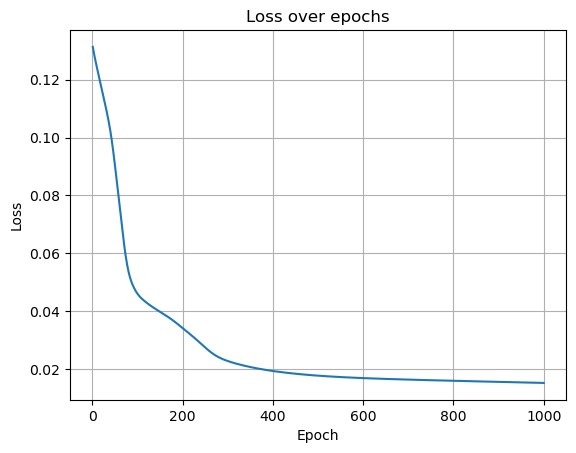

In [53]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, num_epochs=10000):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]', leave=False)
        for batch_idx, data in enumerate(progress_bar):
            inputs, _ = data
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_batches += 1
            progress_bar.set_description(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / num_batches:.4f}')
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)

    return loss_history

loss_history = train_model(model, dataloader, criterion, optimizer, num_epochs=1000)
plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [54]:
X_tensor = torch.Tensor(X).to(device)
with torch.no_grad():
    X_pca = model.encoder(X_tensor).cpu().numpy()
print(X_pca[0])

[-0.42337775  2.3438153 ]


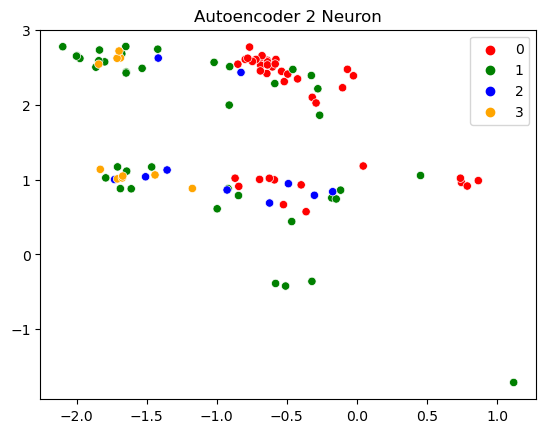

In [55]:
colors = ['red', 'green', 'blue', 'orange']
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=colors)
plt.title("Autoencoder 2 Neuron")
plt.show()

In [62]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(7, 3), 
            nn.ReLU(True),
            nn.Linear(3, 2),      
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 3),
            nn.ReLU(True),
            nn.Linear(3, 7),
            nn.Sigmoid()          
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

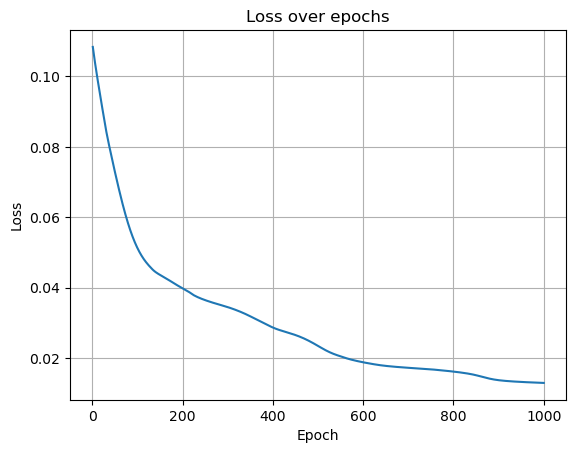

In [64]:
loss_history = train_model(model, dataloader, criterion, optimizer, num_epochs=1000)
plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [65]:
X_tensor = torch.Tensor(X).to(device)
with torch.no_grad():
    X_pca = model.encoder(X_tensor).cpu().numpy()
print(X_pca[0])

[ 3.5598798 -5.4703264]


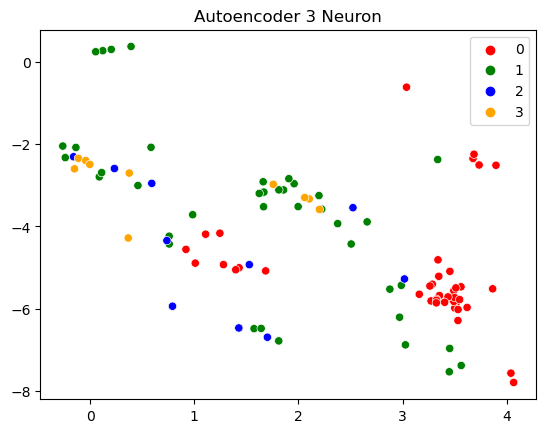

In [66]:
colors = ['red', 'green', 'blue', 'orange']
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=colors)
plt.title("Autoencoder 3 Neuron")
plt.show()

In [73]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(7, 2), 
            nn.ReLU(True),
            nn.Linear(2, 3),      
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 2),
            nn.ReLU(True),
            nn.Linear(2, 7),
            nn.Sigmoid()          
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

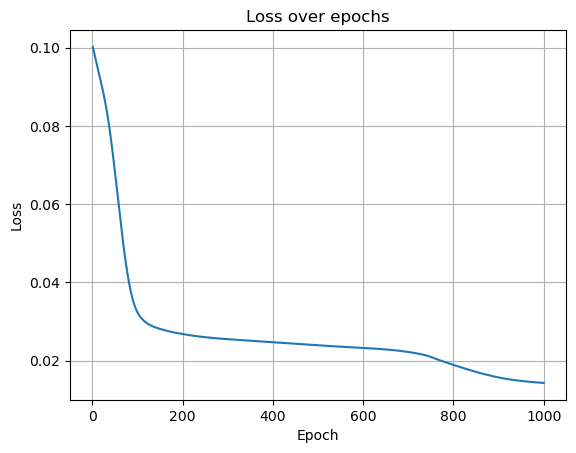

In [75]:
loss_history = train_model(model, dataloader, criterion, optimizer, num_epochs=1000)
plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [76]:
X_tensor = torch.Tensor(X).to(device)
with torch.no_grad():
    X_pca = model.encoder(X_tensor).cpu().numpy()
print(X_pca[0])

[2.7190788  0.24390513 0.5688658 ]


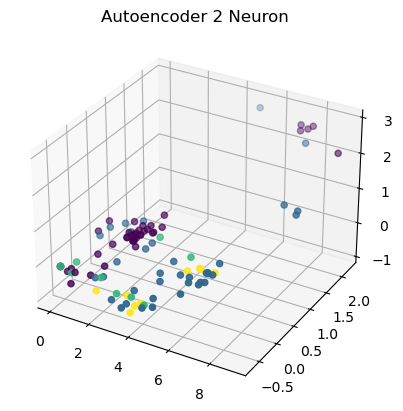

In [77]:
colors = ['red', 'green', 'blue', 'orange']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y)
ax.set_title('Autoencoder 2 Neuron')
plt.show()

In [100]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(7, 3), 
            nn.ReLU(True),
            nn.Linear(3, 3),      
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 3),
            nn.ReLU(True),
            nn.Linear(3, 7),
            nn.Sigmoid()          
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

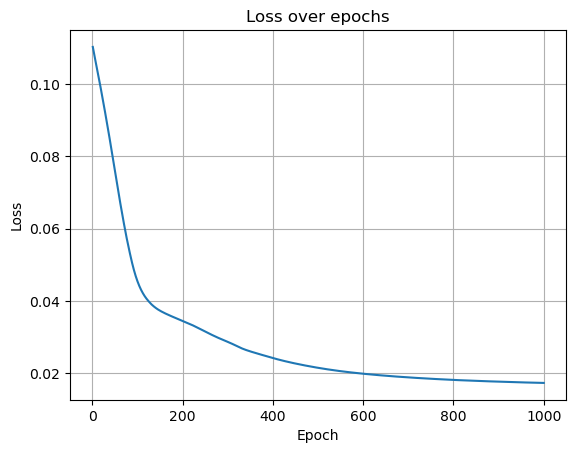

In [102]:
loss_history = train_model(model, dataloader, criterion, optimizer, num_epochs=1000)
plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [103]:
X_tensor = torch.Tensor(X).to(device)
with torch.no_grad():
    X_pca = model.encoder(X_tensor).cpu().numpy()
print(X_pca[0])

[-0.90032494 -0.87766397 -0.18046266]


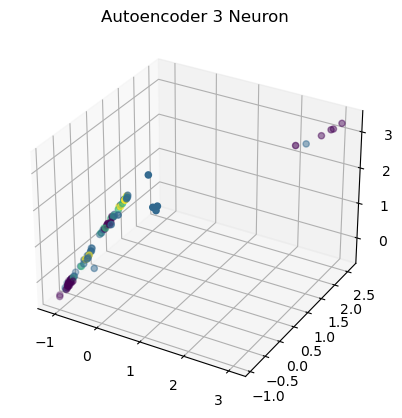

In [104]:
colors = ['red', 'green', 'blue', 'orange']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y)
ax.set_title('Autoencoder 3 Neuron')
plt.show()

In [90]:
X_tsne_2d = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
print(X_tsne_2d[0])

[15.535671 37.454575]


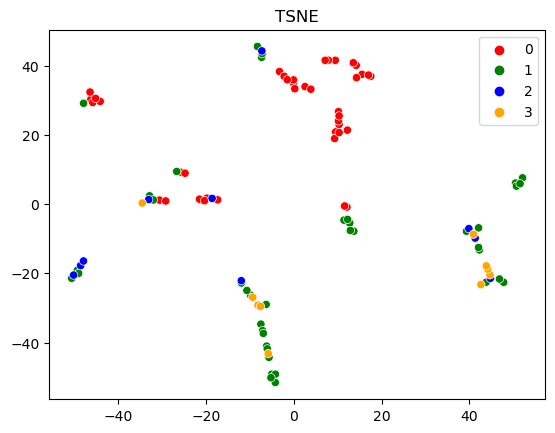

In [91]:
colors = ['red', 'green', 'blue', 'orange']
sns.scatterplot(x=X_tsne_2d[:, 0], y=X_tsne_2d[:, 1], hue=y, palette=colors)
plt.title("TSNE")
plt.show()

In [92]:
X_tsne_3d = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
print(X_tsne_3d[0])

[-11.973691 -58.541454  54.609997]


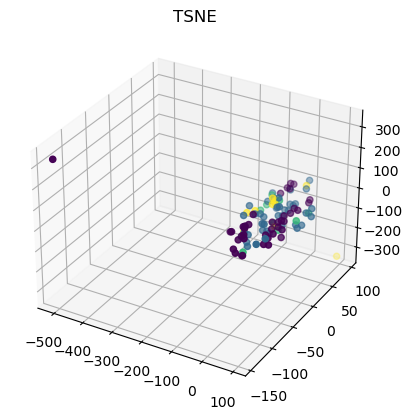

In [93]:
colors = ['red', 'green', 'blue', 'orange']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=y)
ax.set_title('TSNE')
plt.show()